# Basic CNN Model Training


This notebook contains model training process for basic CNN model on three different deepfake detection datasets. The model training splitted into two parts, which are baseline model (base model without dropout) and the dropout model itself.


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import pickle
import os

## Define Dataset Directory


In [2]:
CDF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/Celeb-DF-v2"
DF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DeeperForensics-1.0"
DFDC_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DFDC"

In [3]:
cdf_train_dir = os.path.join(CDF_DATASET_DIR, "Train")
cdf_val_dir = os.path.join(CDF_DATASET_DIR, "Val")

df_train_dir = os.path.join(DF_DATASET_DIR, "Train")
df_val_dir = os.path.join(DF_DATASET_DIR, "Val")

dfdc_train_dir = os.path.join(DFDC_DATASET_DIR, "Train")
dfdc_val_dir = os.path.join(DFDC_DATASET_DIR, "Val")

## Image Data Generator for Each Dataset


In [4]:
def create_image_generator(dataset_dir):
    datagen = ImageDataGenerator(rescale=1.0 / 255)
    image_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(128, 128),
        batch_size=32,
        color_mode="rgb",
        class_mode="binary",
        shuffle=True,
        seed=42,
    )

    return image_generator

In [5]:
print("Celeb-DF-v2 Dataset")
cdf_train_generator = create_image_generator(cdf_train_dir)
cdf_val_generator = create_image_generator(cdf_val_dir)

print("\nDeeperForensics-1.0 Dataset")
df_train_generator = create_image_generator(df_train_dir)
df_val_generator = create_image_generator(df_val_dir)

print("\nDeepfake Detection Challenge Dataset")
dfdc_train_generator = create_image_generator(dfdc_train_dir)
dfdc_val_generator = create_image_generator(dfdc_val_dir)

Celeb-DF-v2 Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

DeeperForensics-1.0 Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

Deepfake Detection Challenge Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Get the Best Hyperparameters from Tuner


In [6]:
TUNER_RESULT_DIR = "/kaggle/input/hp-tuning/tuner-result"
TUNER_PROJECT_NAME = "cnn-best-hp"

In [7]:
tuner = kt.Hyperband(
    directory=TUNER_RESULT_DIR,
    project_name=TUNER_PROJECT_NAME,
    objective="val_accuracy",
    overwrite=False,
)

Reloading Tuner from /kaggle/input/hp-tuning/tuner-result/cnn-best-hp/tuner0.json


In [8]:
best_hp = tuner.get_best_hyperparameters()[0].values
best_hp

{'conv_layers': 6,
 'conv_1_filters': 256,
 'conv_2_filters': 32,
 'conv_3_filters': 160,
 'conv_1_kernel_size': 3,
 'conv_2_kernel_size': 5,
 'conv_3_kernel_size': 5,
 'dense_layers': 6,
 'dense_1_layer_units': 128,
 'dense_2_layer_units': 96,
 'dropout_rate': 0.6000000000000001,
 'learning_rate': 1e-05,
 'dense_3_layer_units': 96,
 'dense_4_layer_units': 96,
 'dense_5_layer_units': 64,
 'conv_4_filters': 128,
 'conv_4_kernel_size': 5,
 'conv_5_filters': 192,
 'conv_6_filters': 128,
 'conv_7_filters': 224,
 'conv_5_kernel_size': 5,
 'conv_6_kernel_size': 5,
 'conv_7_kernel_size': 3,
 'dense_6_layer_units': 128,
 'dense_7_layer_units': 32,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0023'}

## Function to Create a CNN Model


In [9]:
def create_cnn_model(hp, dropout=False, name="cnn_model"):
    model = tf.keras.Sequential(name=name)
    model.add(tf.keras.layers.Input(shape=(128, 128, 3)))

    for i in range(hp.get("conv_layers")):
        filter = hp.get(f"conv_{i+1}_filters")
        kernel_size = hp.get(f"conv_{i+1}_kernel_size")
        model.add(
            tf.keras.layers.Conv2D(
                filter,
                (kernel_size, kernel_size),
                padding="same",
                activation="relu",
                name=f"conv_{i+1}",
            )
        )
        model.add(tf.keras.layers.MaxPooling2D(2, 2, name=f"max_pooling_{i+1}"))

    model.add(tf.keras.layers.Flatten(name="flatten"))

    for i in range(hp.get("dense_layers")):
        dense_units = hp.get(f"dense_{i+1}_layer_units")
        model.add(
            tf.keras.layers.Dense(dense_units, activation="relu", name=f"dense_{i+1}")
        )

    if dropout:
        model.add(tf.keras.layers.Dropout(hp.get("dropout_rate"), name="dropout"))

    model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="output"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.get("learning_rate")),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )

    return model

## Function to Plot Train Results


In [10]:
def plot_train_result(history, title="Training Result"):
    plt.figure(figsize=(12, 4))
    plt.subplots_adjust(top=0.8)
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history["accuracy"], label="Train")
    plt.plot(history["val_accuracy"], label="Val")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

## Function to Save Model Training History


In [11]:
def save_model_and_history(model, history, model_name):
    model_filename = f"{model_name}_model.keras"
    history_filename = f"{model_name}_history.pkl"

    model.save(model_filename)
    print(f"Model saved at {model_filename}")

    with open(history_filename, "wb") as f:
        pickle.dump(history.history, f)
        print(f"Training history saved at {history_filename}")

## Model Training


In [12]:
NUM_EPOCHS = 10

### Baseline Basic CNN


#### Celeb-DF-v2 Dataset


In [13]:
baseline_cnn_cdf_model = create_cnn_model(best_hp, name="baseline_cnn_cdf")
baseline_cnn_cdf_model.summary()

Model: "baseline_cnn_cdf"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_1 (MaxPooling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 32)     │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2 (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 160)    │       128,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_3 (MaxPooling2D)    │ (None, 16, 16, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 16, 16, 128)    │       512,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_4 (MaxPooling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 8, 8, 192)      │       614,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_5 (MaxPooling2D)    │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 4, 4, 128)      │       614,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_6 (MaxPooling2D)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,192,737 (8.36 MB)

 Trainable params: 2,192,737 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
baseline_cnn_cdf_history = baseline_cnn_cdf_model.fit(
    cdf_train_generator, validation_data=cdf_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731544327.609068     106 service.cc:145] XLA service 0x785a30001410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731544327.609116     106 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/438 ━━━━━━━━━━━━━━━━━━━━ 1:29:32 12s/step - accuracy: 0.3750 - loss: 0.6934

I0000 00:00:1731544335.302091     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 116s 238ms/step - accuracy: 0.5021 - loss: 0.6931 - val_accuracy: 0.6100 - val_loss: 0.6930
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.5393 - loss: 0.6916 - val_accuracy: 0.5415 - val_loss: 0.6593
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.6877 - loss: 0.6103 - val_accuracy: 0.6320 - val_loss: 0.6575
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.7456 - loss: 0.5450 - val_accuracy: 0.6180 - val_loss: 0.7500
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.7739 - loss: 0.5048 - val_accuracy: 0.6295 - val_loss: 0.7577
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.8095 - loss: 0.4506 - val_accuracy: 0.6070 - val_loss: 0.7789
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.8225 - loss: 0.4216 - val_accuracy: 0.6195 - val_loss: 0.8490
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8466 - loss: 0.3727 - val_accur

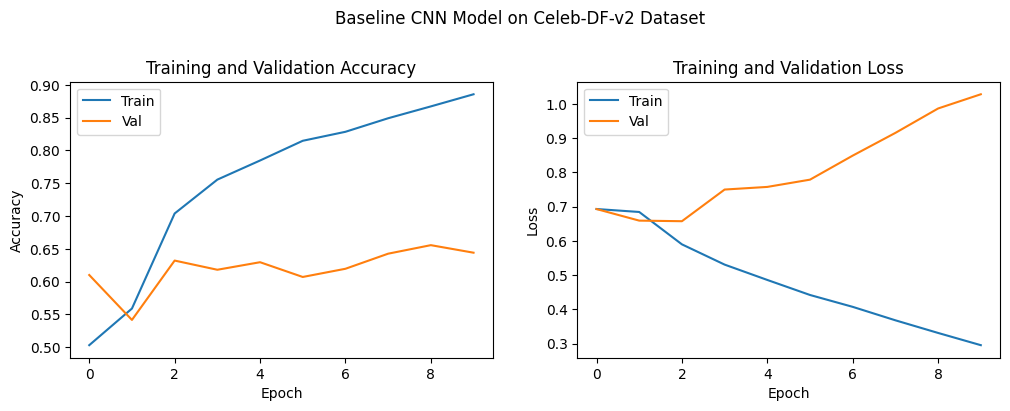

In [15]:
plot_train_result(
    baseline_cnn_cdf_history.history, title="Baseline CNN Model on Celeb-DF-v2 Dataset"
)

In [16]:
save_model_and_history(
    baseline_cnn_cdf_model, baseline_cnn_cdf_history, "baseline_cnn_cdf"
)

Model saved at baseline_cnn_cdf_model.keras
Training history saved at baseline_cnn_cdf_history.pkl


#### DeeperForensics-1.0 Dataset


In [17]:
baseline_cnn_df_model = create_cnn_model(best_hp, name="baseline_cnn_df")
baseline_cnn_df_model.summary()

Model: "baseline_cnn_df"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_1 (MaxPooling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 32)     │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2 (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 160)    │       128,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_3 (MaxPooling2D)    │ (None, 16, 16, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 16, 16, 128)    │       512,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_4 (MaxPooling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 8, 8, 192)      │       614,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_5 (MaxPooling2D)    │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 4, 4, 128)      │       614,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_6 (MaxPooling2D)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,192,737 (8.36 MB)

 Trainable params: 2,192,737 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
baseline_cnn_df_history = baseline_cnn_df_model.fit(
    df_train_generator, validation_data=df_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 124s 267ms/step - accuracy: 0.5481 - loss: 0.6796 - val_accuracy: 0.7240 - val_loss: 0.4855
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.8789 - loss: 0.2967 - val_accuracy: 0.8935 - val_loss: 0.2682
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.9593 - loss: 0.1174 - val_accuracy: 0.9210 - val_loss: 0.2827
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9788 - loss: 0.0694 - val_accuracy: 0.9125 - val_loss: 0.2389
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.9888 - loss: 0.0437 - val_accuracy: 0.8940 - val_loss: 0.5242
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9897 - loss: 0.0384 - val_accuracy: 0.9165 - val_loss: 0.2591
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.9903 - loss: 0.0320 - val_accuracy: 0.9010 - val_loss: 0.5760
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9929 - loss: 0.0238 

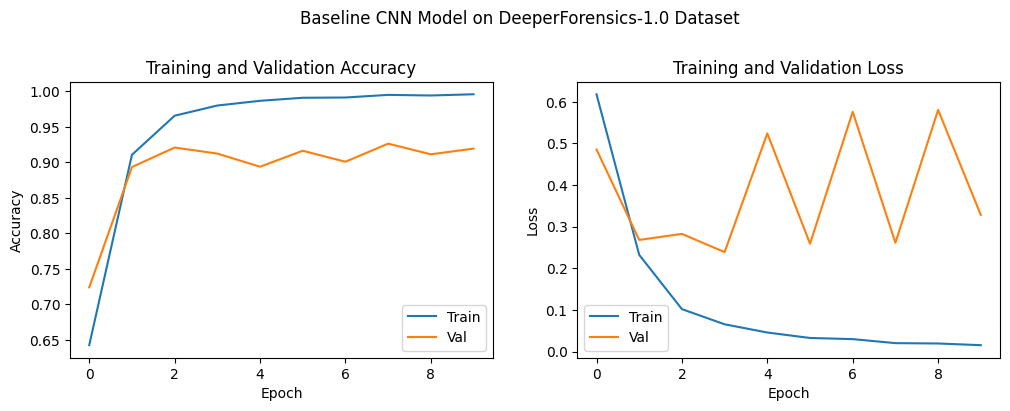

In [19]:
plot_train_result(
    baseline_cnn_df_history.history,
    title="Baseline CNN Model on DeeperForensics-1.0 Dataset",
)

In [20]:
save_model_and_history(
    baseline_cnn_df_model, baseline_cnn_df_history, "baseline_cnn_df"
)

Model saved at baseline_cnn_df_model.keras
Training history saved at baseline_cnn_df_history.pkl


#### DFDC Dataset


In [21]:
baseline_cnn_dfdc_model = create_cnn_model(best_hp, name="baseline_cnn_dfdc")
baseline_cnn_dfdc_model.summary()

Model: "baseline_cnn_dfdc"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_1 (MaxPooling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 32)     │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2 (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 160)    │       128,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_3 (MaxPooling2D)    │ (None, 16, 16, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 16, 16, 128)    │       512,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_4 (MaxPooling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 8, 8, 192)      │       614,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_5 (MaxPooling2D)    │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 4, 4, 128)      │       614,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_6 (MaxPooling2D)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,192,737 (8.36 MB)

 Trainable params: 2,192,737 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
baseline_cnn_dfdc_history = baseline_cnn_dfdc_model.fit(
    dfdc_train_generator, validation_data=dfdc_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 120s 260ms/step - accuracy: 0.5008 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6919
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.5224 - loss: 0.6885 - val_accuracy: 0.5255 - val_loss: 0.7075
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.6289 - loss: 0.6399 - val_accuracy: 0.5255 - val_loss: 0.7672
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.6993 - loss: 0.5626 - val_accuracy: 0.5640 - val_loss: 0.8526
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.7585 - loss: 0.4908 - val_accuracy: 0.5395 - val_loss: 1.1075
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.8259 - loss: 0.3860 - val_accuracy: 0.5665 - val_loss: 1.3709
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.8653 - loss: 0.3158 - val_accuracy: 0.5855 - val_loss: 1.3910
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8955 - loss: 0.2552 

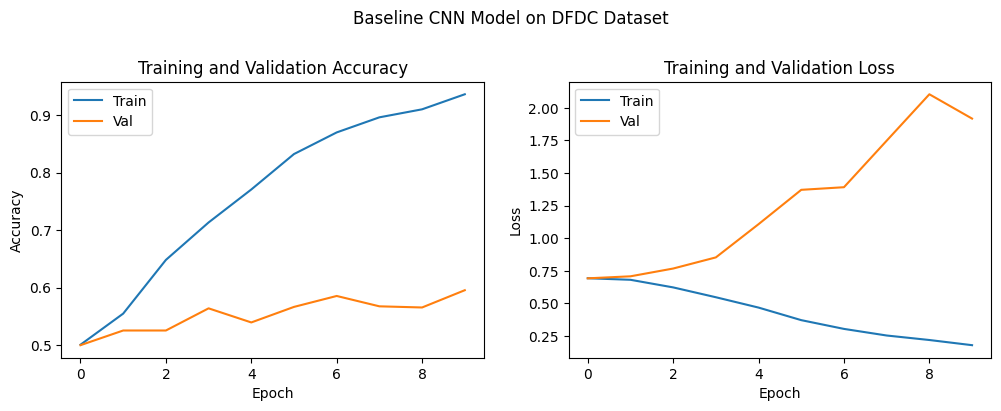

In [23]:
plot_train_result(
    baseline_cnn_dfdc_history.history, title="Baseline CNN Model on DFDC Dataset"
)

In [24]:
save_model_and_history(
    baseline_cnn_dfdc_model, baseline_cnn_dfdc_history, "baseline_cnn_dfdc"
)

Model saved at baseline_cnn_dfdc_model.keras
Training history saved at baseline_cnn_dfdc_history.pkl


### Dropout Basic CNN Model Training


#### Celeb-DF-v2 Dataset


In [25]:
dropout_cnn_cdf_model = create_cnn_model(best_hp, dropout=True, name="dropout_cnn_cdf")
dropout_cnn_cdf_model.summary()

Model: "dropout_cnn_cdf"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_1 (MaxPooling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 32)     │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2 (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 160)    │       128,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_3 (MaxPooling2D)    │ (None, 16, 16, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 16, 16, 128)    │       512,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_4 (MaxPooling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 8, 8, 192)      │       614,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_5 (MaxPooling2D)    │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 4, 4, 128)      │       614,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_6 (MaxPooling2D)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,192,737 (8.36 MB)

 Trainable params: 2,192,737 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
dropout_cnn_cdf_history = dropout_cnn_cdf_model.fit(
    cdf_train_generator, validation_data=cdf_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - accuracy: 0.5056 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.5010 - loss: 0.6932 - val_accuracy: 0.5055 - val_loss: 0.6930
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.5163 - loss: 0.6927 - val_accuracy: 0.6510 - val_loss: 0.6849
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.6322 - loss: 0.6539 - val_accuracy: 0.6480 - val_loss: 0.6565
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.7333 - loss: 0.5708 - val_accuracy: 0.6480 - val_loss: 0.6702
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7725 - loss: 0.5180 - val_accuracy: 0.6350 - val_loss: 0.6660
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.7934 - loss: 0.4961 - val_accuracy: 0.6380 - val_loss: 0.7082
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.8149 - loss: 0.4542 - 

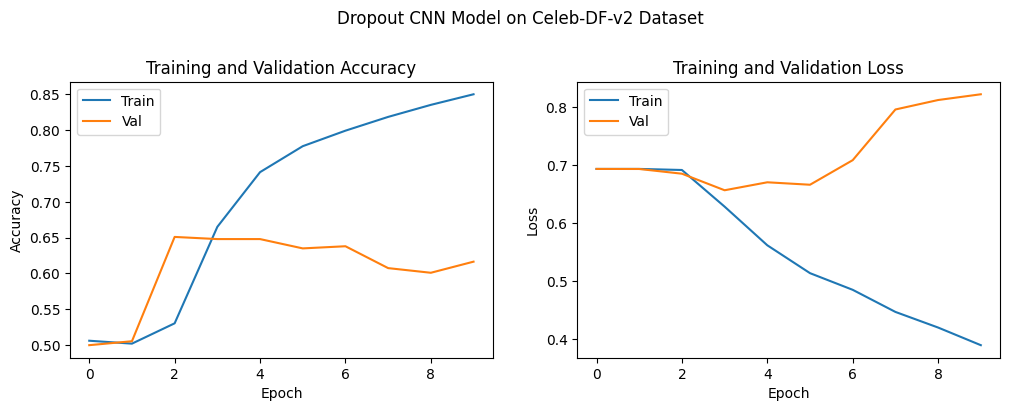

In [27]:
plot_train_result(
    dropout_cnn_cdf_history.history, title="Dropout CNN Model on Celeb-DF-v2 Dataset"
)

In [28]:
save_model_and_history(
    dropout_cnn_cdf_model, dropout_cnn_cdf_history, "dropout_cnn_cdf"
)

Model saved at dropout_cnn_cdf_model.keras
Training history saved at dropout_cnn_cdf_history.pkl


#### DeeperForensics-1.0 Dataset


In [29]:
dropout_cnn_df_model = create_cnn_model(best_hp, dropout=True, name="dropout_cnn_df")
dropout_cnn_df_model.summary()

Model: "dropout_cnn_df"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_1 (MaxPooling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 32)     │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2 (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 160)    │       128,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_3 (MaxPooling2D)    │ (None, 16, 16, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 16, 16, 128)    │       512,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_4 (MaxPooling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 8, 8, 192)      │       614,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_5 (MaxPooling2D)    │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 4, 4, 128)      │       614,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_6 (MaxPooling2D)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,192,737 (8.36 MB)

 Trainable params: 2,192,737 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
dropout_cnn_df_history = dropout_cnn_df_model.fit(
    df_train_generator, validation_data=df_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 36s 66ms/step - accuracy: 0.5383 - loss: 0.6890 - val_accuracy: 0.8725 - val_loss: 0.4920
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.8174 - loss: 0.4341 - val_accuracy: 0.9080 - val_loss: 0.2616
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9418 - loss: 0.1786 - val_accuracy: 0.9210 - val_loss: 0.2535
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.9703 - loss: 0.1041 - val_accuracy: 0.9435 - val_loss: 0.2676
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.9784 - loss: 0.0762 - val_accuracy: 0.9465 - val_loss: 0.2451
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.9878 - loss: 0.0493 - val_accuracy: 0.9435 - val_loss: 0.3106
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.9894 - loss: 0.0392 - val_accuracy: 0.9430 - val_loss: 0.3191
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.9921 - loss: 0.0357 - 

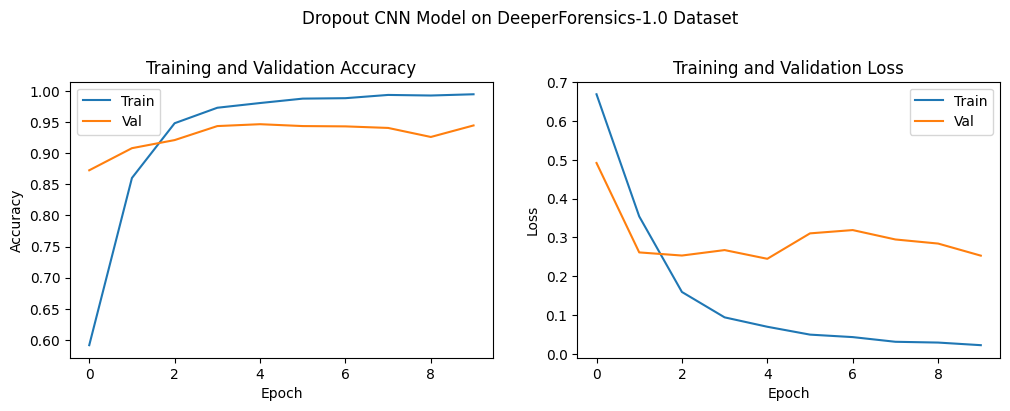

In [31]:
plot_train_result(
    dropout_cnn_df_history.history,
    title="Dropout CNN Model on DeeperForensics-1.0 Dataset",
)

In [32]:
save_model_and_history(dropout_cnn_df_model, dropout_cnn_df_history, "dropout_cnn_df")

Model saved at dropout_cnn_df_model.keras
Training history saved at dropout_cnn_df_history.pkl


#### DFDC Dataset


In [33]:
dropout_cnn_dfdc_model = create_cnn_model(
    best_hp, dropout=True, name="dropout_cnn_dfdc"
)
dropout_cnn_dfdc_model.summary()

Model: "dropout_cnn_dfdc"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_1 (MaxPooling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 32)     │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2 (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 160)    │       128,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_3 (MaxPooling2D)    │ (None, 16, 16, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 16, 16, 128)    │       512,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_4 (MaxPooling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 8, 8, 192)      │       614,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_5 (MaxPooling2D)    │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 4, 4, 128)      │       614,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_6 (MaxPooling2D)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,192,737 (8.36 MB)

 Trainable params: 2,192,737 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
dropout_cnn_dfdc_history = dropout_cnn_dfdc_model.fit(
    dfdc_train_generator, validation_data=dfdc_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.5061 - loss: 0.6931 - val_accuracy: 0.5545 - val_loss: 0.6930
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.5312 - loss: 0.6911 - val_accuracy: 0.5020 - val_loss: 0.6945
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.6051 - loss: 0.6679 - val_accuracy: 0.5205 - val_loss: 0.7146
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.6647 - loss: 0.6215 - val_accuracy: 0.5125 - val_loss: 0.7856
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.7160 - loss: 0.5636 - val_accuracy: 0.5060 - val_loss: 0.9685
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.7722 - loss: 0.4886 - val_accuracy: 0.5735 - val_loss: 0.9964
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.8128 - loss: 0.4154 - val_accuracy: 0.5640 - val_loss: 1.2897
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.8479 - loss: 0.3498 - 

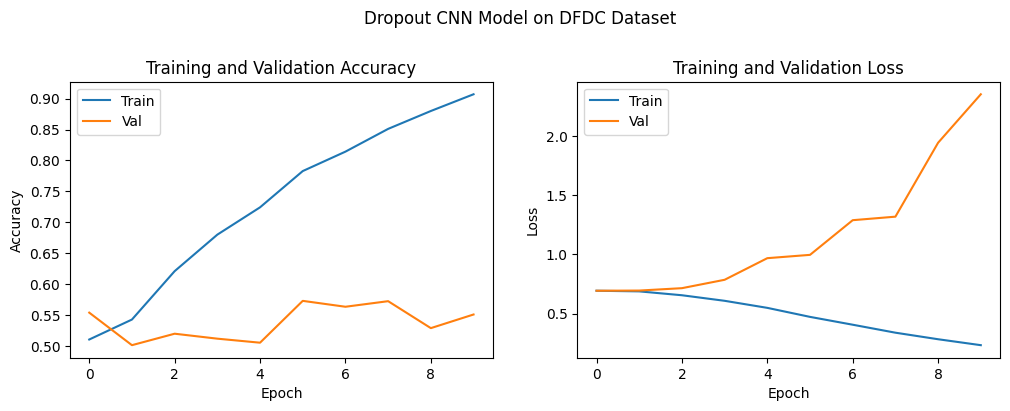

In [35]:
plot_train_result(
    dropout_cnn_dfdc_history.history, title="Dropout CNN Model on DFDC Dataset"
)

In [36]:
save_model_and_history(
    dropout_cnn_dfdc_model, dropout_cnn_dfdc_history, "dropout_cnn_dfdc"
)

Model saved at dropout_cnn_dfdc_model.keras
Training history saved at dropout_cnn_dfdc_history.pkl
